# 计算机视觉
## 数据增广
- 增加已有数据集，使得有更多的多样性
    - 在语言里面加入各种不同的背景噪音
    - 改变图片的颜色和形状
- 使用增强数据集训练
- 翻转、切割、颜色以及其他
- 数据增广通过变形数据来获取多样性从而使得模型泛化性能更好


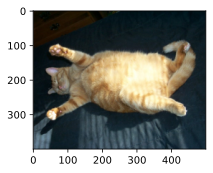

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../data/img/cat1.jpg')
d2l.plt.imshow(img);


In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

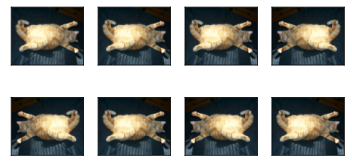

In [3]:
# 左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

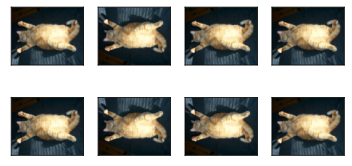

In [4]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

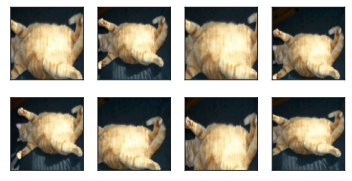

In [5]:
# 裁剪
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

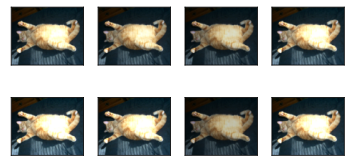

In [6]:
# 改变亮度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

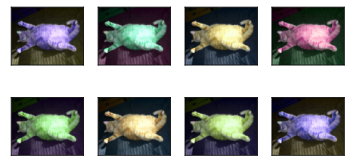

In [7]:
# 色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

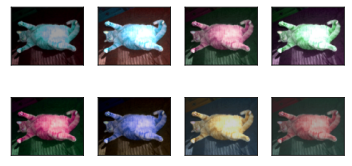

In [8]:
# 同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

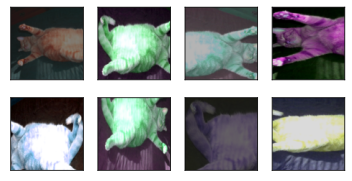

In [9]:
# 结合多种图像增广方法
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

Files already downloaded and verified


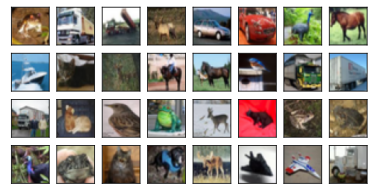

In [10]:
# 使用图像增广进行训练
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [11]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])
# 训练数据变换一下
# 测试数据不变
test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [12]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [13]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [14]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

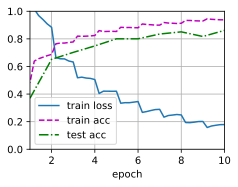

In [15]:
train_with_data_aug(train_augs, test_augs, net)

## 微调
- 神经网络一般可以分为两块：
    - 特征抽取将原始像素变成容易线性分割的特征
    - 线性分类器来做分类
- 利用源数据训练，再对目标数据集进行微调
- 神经网络通常学习有层次的特征表示
    - 低层次的特征更加通用
    - 高层次的特征则更跟数据集相关
- 可以固定底部一些层的参数，不参与更新
- 微调通过使用在大数据上得到的预训练好的模型来初始化模型权重来完成提升精度
- 预训练模型质量很重要
- 微调通常速度更快、精度更高

In [3]:
# 在一个小型数据集上微调ResNet模型
# 这个小型数据集包含数千张包含热狗和不包含热狗的图像，我们将使用微调模型来识别图像中是否包含热狗。
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

#@save 获取数据集
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

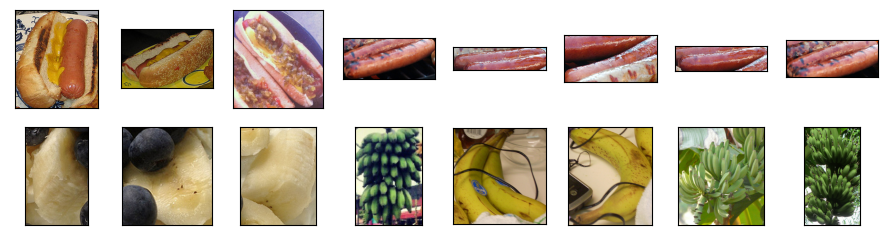

In [4]:
# 读取训练和测试数据集中的所有图像文件
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))
# 显示了前8个正类样本图片和最后8张负类样本图片
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [6]:
 # 定义和初始化模型
pretrained_net = torchvision.models.resnet18(pretrained=True)

pretrained_net.fc

D:\conda\envs\A1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\conda\envs\A1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ZOO/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Linear(in_features=512, out_features=1000, bias=True)

In [7]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [8]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

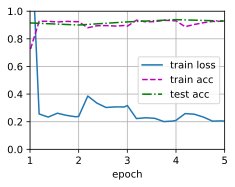

In [9]:
train_fine_tuning(finetune_net, 5e-5)

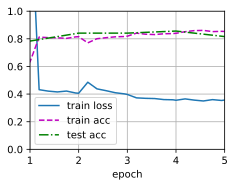

In [10]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

## 锚框
- 目标检测算法是基于锚框的
    - 提出多个被称为锚框的区域（边缘框）
    - 预测每个锚框里是否含有关注的物体
    - 如果是，预测从这个锚框到真实边缘框的偏移
- IoU-交并比
    - 用于计算两个框之间的相似度
        - 0表示无重叠，1表示重合
- 赋予锚框标号
    - 每个锚框是一个训练样本
    - 将每个锚框要么标注成背景，要么关联上一个真实边缘框
    - 生成大量的锚框，会导致大量的负类样本
- 首先生成大量锚框，并赋予标号，每个锚框作为一个样本进行训练
- 在预测时，使用NMS来去掉冗余的预测

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 修改输出精度，以获得更简洁的输出

In [2]:
#@save 指定输入图像、尺寸列表和宽高比列表，然后此函数将返回所有的锚框
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [4]:
img = d2l.plt.imread('../data/img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # 返回的锚框变量Y的形状是（批量大小，锚框的数量，4）

561 728


torch.Size([1, 2042040, 4])

In [5]:
boxes = Y.reshape(h, w, 5, 4) # 将锚框变量Y的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)
boxes[250, 250, 0, :] # 访问以（250,250）为中心的第一个锚框

tensor([0.06, 0.07, 0.63, 0.82])

In [6]:
#@save 在图像上绘制多个边界框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

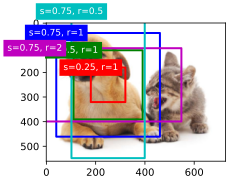

In [7]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5']) # 恢复它们原始的坐标值

In [9]:
#@save 计算它们成对的交并比
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [10]:
#@save 将真实边界框分配给锚框
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [11]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [12]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

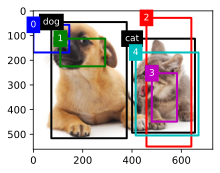

In [13]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [14]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [15]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [16]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [17]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [18]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [19]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [20]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

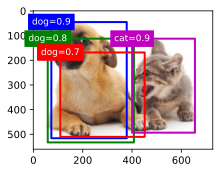

In [21]:
fig = d2l.plt.imshow(img) # 在图像上绘制这些预测边界框和置信度
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [22]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

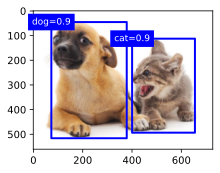

In [23]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label) # 输出由非极大值抑制保存的最终预测边界框

## 目标检测和边缘框
- 边缘框
    - 一个边缘框可以通过4个数字定义
        - （左上x，左上y，右下x，右下y）
        - （左上x，左上y，宽，高）
- 目标检测数据集
    - 每行表示一个物体
        - 图片文件名，物体类别，边缘框
- 物体检测识别图片里多个物体的类别和位置
- 位置通常用边缘框表示



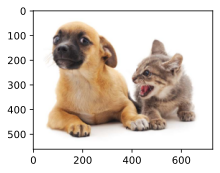

In [25]:
%matplotlib inline
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread('../data/img/catdog.jpg')
d2l.plt.imshow(img);

In [26]:
#@save 边界框
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save box_corner_to_center从两角表示法转换为中心宽度表示法，而box_center_to_corner反之亦然。
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [27]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [28]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [29]:
#@save 我们定义一个辅助函数bbox_to_rect。 它将边界框表示成matplotlib的边界框格式
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

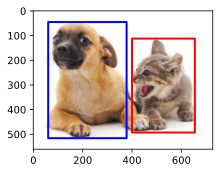

In [30]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 目标检测数据集
- 为了快速测试目标检测模型，我们收集并标记了一个小型数据集


In [31]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save 包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [32]:
#@save 使用read_data_bananas函数读取图像和标签
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [33]:
#@save 创建一个自定义Dataset实例来加载香蕉检测数据集
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [34]:
#@save 训练集和测试集返回两个数据加载器实例
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [35]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

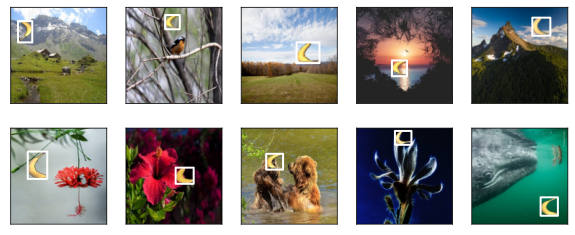

In [36]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## R-CNN
- R-CNN是最早、最有名的一类基于锚框和CNN的目标检测算法
- Fast/Faster R-CNN持续提升性能
- Faster R-CNN和Mask R-CNN是在求最高精度场景下的常用算法

## SDD
- 单发多框检测
- 通过单神经网络来检测模型
- 以每个像素为中心产生多个锚框
- 在多个段的输出上进行多尺度的检测

## YOLO
- 将图片均匀分为SxS个锚框
- 每个锚框预测B个边缘框

## 语义分割
- 语义分割将图片中的每个像素分类到对应的类别
- 应用：背景虚化、无人驾驶的路面分割

## 转置卷积
- 卷积不会增大输入的高宽，转置卷积会
- 转置卷积是一种卷积，它将输入和核进行了重新排列
- 通常用作上采样
- 不等同于数学上的反卷积操作


In [37]:
import torch
from torch import nn
from d2l import torch as d2l

def trans_conv(X, K): # 对输入矩阵X和卷积核矩阵K实现基本的转置卷积运算trans_conv
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [38]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [39]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [40]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

In [41]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

In [42]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

In [43]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

In [44]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

In [45]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

## 全连接卷积神经网络FCN
- FCN是深度神经网络来做语义分割的奠基性工作
- 用转置卷积层来替换CNN最后的全连接层，从而实现每个像素的预测


In [47]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [48]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [49]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [50]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [51]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [52]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [54]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../data/img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


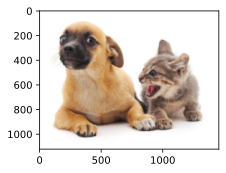

In [55]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [56]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## 样式迁移
- 将样式图片中的样式迁移到内容图片上，得到合成图片

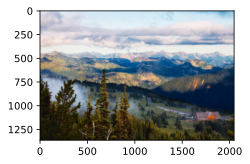

In [58]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../data/img/rainier.jpg')
d2l.plt.imshow(content_img);

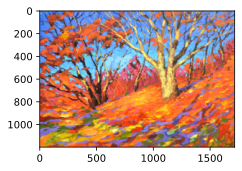

In [60]:
style_img = d2l.Image.open('../data/img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [61]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [64]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\ZOO/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [65]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l



In [66]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [67]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [68]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

In [70]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)